# load the packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



# load the grid

In [4]:
# define basin we want
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [5]:
iB = 6    # read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


In [6]:
mymsk3 = np.tile(mymsk[np.newaxis,:,:],(nz,1,1)) * mygrid['hFacC']
mymsk3.shape

(50, 1350, 270)

# timesteps

In [7]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

# ocean and ice
AB_gT=0
AB_gS=0

In [40]:
# years = list(np.arange(2003,2018,1))  # 15 year period
years = [2003,2004]
years = [str(i) for i in years]
years = np.array(years)
# years

In [41]:
# write the datetimes for the later period
times = {}

for year in years:
    times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period

tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)
tsstr.shape
datetimes.shape

(24,)

In [42]:
# dates

In [43]:
# for one year
# tsstr = tsstr[:7]
# datetimes = datetimes[:7]
tsstr = tsstr[6:13]
datetimes = datetimes[6:13]
datetimes.shape

(7,)

In [44]:
# 'datetimes' is a list of datetime objects
dt = [(datetimes[i+1] - datetimes[i]).total_seconds() for i in range(len(datetimes) - 1)]
dt = np.array(dt)
dt.shape

(6,)

# create the J terms

In general, when we create the time-mean for these terms we are interested in the mean weighted by depth

### For salt

We need to find a way to do this more efficiently

In [45]:
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisSALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

SALTDR =  (SALTDR[1:, :, :,:] - SALTDR[:-1, :,:, :]) / dt[:,np.newaxis,np.newaxis,np.newaxis]    # PSU.m/s
SALTDR.shape

(6, 50, 1350, 270)

In [46]:
tmptend = myparms['rhoconst'] * (SALTDR - AB_gS) * np.tile(mk3D_mod(RAC,SALTDR[0])[np.newaxis,:,:,:],(SALTDR.shape[0],1,1,1))    # kg/m^3 * PSU.m/s * m^2 = g/s
budgO = {}
budgO['saltfluxes'] = {}
budgI = {}
budgI['saltfluxes'] = {}
budgOI = {}

# ocean
budgO['saltfluxes']['tend'] = tmptend
budgO['salttend'] = np.nansum(tmptend,axis=1)

In [47]:
del SALTDR,tmptend

In [48]:
# read adv and dfe
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# do this onle for datetimes[1:] so we can set it in the file
saltfluxeshconv = np.zeros((len(tsstr)-1,nz,ny,nx))
advfluxeshconv = np.zeros((len(tsstr)-1,nz,ny,nx))
dffluxeshconv = np.zeros((len(tsstr)-1,nz,ny,nx))
                     
for t in range(len(tsstr[1:])):
    t2 = int(tsstr[t + 1])
    # read the files
    ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
    DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
    DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
    
    tmpUo = myparms['rhoconst'] * (ADVx_SLT + DFxE_SLT)
    tmpVo = myparms['rhoconst'] * (ADVy_SLT + DFyE_SLT)
    
    # reshape and get the faces
    tmpUo = tmpUo.reshape(nz,ny,nx)
    tmpVo = tmpVo.reshape(nz,ny,nx)
    tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
    tmpVo = get_aste_faces(tmpVo,nfx,nfy)

    # set in the larger array
    saltfluxeshconv[t] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)


    # also do for adv and df
    tmpUo = get_aste_faces(ADVx_SLT.reshape(nz,ny,nx),nfx,nfy)
    tmpVo = get_aste_faces(ADVy_SLT.reshape(nz,ny,nx),nfx,nfy)
    advfluxeshconv[t] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

    tmpUo = get_aste_faces(DFxE_SLT.reshape(nz,ny,nx),nfx,nfy)
    tmpVo = get_aste_faces(DFyE_SLT.reshape(nz,ny,nx),nfx,nfy)
    dffluxeshconv[t] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s


budgO['saltfluxes']['hconv'] = saltfluxeshconv
budgO['saltfluxes']['ADV_hconv'] = advfluxeshconv
budgO['saltfluxes']['DF_hconv'] = dffluxeshconv

In [49]:
del ADVx_SLT, ADVy_SLT, DFxE_SLT, DFyE_SLT
del saltfluxeshconv,advfluxeshconv,dffluxeshconv

In [50]:
# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX",'oceFWflx','SIatmFW'])   # add in other terms to look at balance
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# read all the files
oceSPflx = np.zeros((len(tsstr)-1,ny,nx))
SFLUX = np.zeros((len(tsstr)-1,ny,nx))
oceFWflx = np.zeros((len(tsstr)-1,ny,nx))
SIatmFW = np.zeros((len(tsstr)-1,ny,nx))

# loop and add to list
for t in range(len(tsstr[1:])):
    t2 = int(tsstr[t+1])  # +1 so we can read end of budg time steps
    
    tmpoceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])   # g/m^2/s
    tmpSFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])      # g/m^2/s
    tmpoceFWflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])   # kg/m^2/s
    tmpSIatmFW,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])    # kg/m^2/s

    tmpoceSPflx = tmpoceSPflx.reshape(ny,nx)
    tmpSFLUX = tmpSFLUX.reshape(ny,nx)
    tmpoceFWflx = tmpoceFWflx.reshape(ny,nx)
    tmpSIatmFW = tmpSIatmFW.reshape(ny,nx)

    # add to bigger array
    oceSPflx[t] = tmpoceSPflx
    SFLUX[t] = tmpSFLUX
    oceFWflx[t] = tmpoceFWflx
    SIatmFW[t] = tmpSIatmFW

# array to store all the files
oceSflux = np.zeros((len(tsstr)-1,ny,nx))
WSLTMASS = np.zeros((len(tsstr)-1,ny,nx))
SRELAX = np.zeros((len(tsstr)-1,ny,nx))

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

# loop and add to list
for t in range(len(tsstr[1:])):
    t2 = int(tsstr[t+1])

    tmpoceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    tmpWSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
    tmpSRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
    tmpoceSflux = tmpoceSflux.reshape(ny,nx)
    tmpWSLTMASS = tmpWSLTMASS.reshape(ny,nx)
    tmpSRELAX = tmpSRELAX.reshape(ny,nx)

    # add to bigger array
    oceSflux[t] = tmpoceSflux
    WSLTMASS[t] = tmpWSLTMASS
    SRELAX[t] = tmpSRELAX

In [51]:
# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

oceSPtnd = np.zeros((len(tsstr)-1,nz,ny,nx))
KPPg_SLT = np.zeros((len(tsstr)-1,nz,ny,nx))

# loop and add to list
for t in range(len(tsstr[1:])):
    t2 = int(tsstr[t+1])  # +1 so we can read end of budg time steps

    tmpoceSPtnd,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    tmpKPPg_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
    tmpoceSPtnd = tmpoceSPtnd.reshape(nz,ny,nx)
    tmpKPPg_SLT = tmpKPPg_SLT.reshape(nz,ny,nx)

    oceSPtnd[t] = tmpoceSPtnd
    KPPg_SLT[t] = tmpKPPg_SLT


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT","DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# do same time-reading
ADVr_SLT = np.zeros((len(tsstr)-1,nz,ny,nx))
DFrE_SLT = np.zeros((len(tsstr)-1,nz,ny,nx))
DFrI_SLT = np.zeros((len(tsstr)-1,nz,ny,nx))

# loop and add to list
for t in range(len(tsstr[1:])):
    t2 = int(tsstr[t+1])  # +1 so we can read end of budg time steps

    tmpADVr_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
    tmpDFrE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
    tmpDFrI_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
    tmpADVr_SLT = tmpADVr_SLT.reshape(nz,ny,nx)
    tmpDFrE_SLT = tmpDFrE_SLT.reshape(nz,ny,nx)
    tmpDFrI_SLT = tmpDFrI_SLT.reshape(nz,ny,nx)

    # add to bigger array
    ADVr_SLT[t] = tmpADVr_SLT
    DFrE_SLT[t] = tmpDFrE_SLT
    DFrI_SLT[t] = tmpDFrI_SLT

In [52]:
if myparms["useRFWF"]==0 or myparms['useNLFS']==0:
    print('do nothing')
else:
    oceSflux = 0 * oceSflux

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WSLTMASS=0*WSLTMASS

budgO['saltzconv'] = SFLUX + oceSPflx                  # W/m^2
zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s
budgI['saltzconv'] = -budgO['saltzconv'] + SRELAX

if myparms['useNLFS']==0:
    budgO['saltzconv'] = budgO['saltzconv'] - myparms['rhoconst']*WSLTMASS

if myparms['useRFWF']==0 or myparms['useNLFS']==0:
    budgI['saltzconv']=-oceSflux

In [53]:
# tester to look at shapes


nr = mygrid['RC'].shape[0]
# break trWtop down into smaller terms
trWtopADV = -(ADVr_SLT)*myparms['rhoconst']           # g/s
trWtopDF = -(DFrE_SLT+DFrI_SLT)*myparms['rhoconst']   # g/s
trWtopKPP = -(KPPg_SLT)*myparms['rhoconst']           # g/s
trWtop = trWtopADV + trWtopDF + trWtopKPP             # g/s 

In [54]:
nr = mygrid['RC'].shape[0]
# break trWtop down into smaller terms
trWtopADV = -(ADVr_SLT)*myparms['rhoconst']           # g/s
trWtopDF = -(DFrE_SLT+DFrI_SLT)*myparms['rhoconst']   # g/s
trWtopKPP = -(KPPg_SLT)*myparms['rhoconst']           # g/s
trWtop = trWtopADV + trWtopDF + trWtopKPP             # g/s 

print(trWtop.shape)
sptop = np.tile(oceSPflx[:,np.newaxis,:,:],(1,nz,1,1)) - np.cumsum(oceSPtnd, axis=1)        # we include this in our zconv_top term
sptop = sptop * np.tile(RAC3[np.newaxis,:,:,:],(len(tsstr)-1,1,1,1))        # g/s

trWtop[:,1:,:,:] = trWtop[:,1:,:,:] + sptop[:,:-1,:,:]
trWtop[:,0,:,:] = budgO['saltzconv'] * RAC    # g/s top layer is surface flux

trWbot = np.zeros_like(trWtop)
trWbot[:,:-1,:,:] = trWtop[:,1:,:,:]
trWbot[:,-1,:,:] = 0

budgO['saltfluxes']['trWtop'] = trWtop     # g/s
budgO['saltfluxes']['trWbot'] = trWbot     # g/s

budgI['saltfluxes']['trWtop'] = -RAC*0
budgI['saltfluxes']['trWbot'] = budgO['saltfluxes']['trWtop'][:,0,:,:]  # surface because ice

budgO['saltfluxes']['zconv'] = budgO['saltfluxes']['trWtop'] - budgO['saltfluxes']['trWbot']
budgO['saltzconv'] = np.tile(RAC[np.newaxis,:,:],(len(tsstr)-1,1,1)) * budgO['saltzconv']   # g/s
budgI['saltzconv'] = np.tile(RAC[np.newaxis,:,:],(len(tsstr)-1,1,1)) * budgI['saltzconv']   # g/s
budgOI['saltzconv'] = budgO['saltzconv'] + budgI['saltzconv']

(6, 50, 1350, 270)


In [55]:
del trWtop,trWbot

In [56]:
# do vertical convergence for ADV and DF terms
tmpadv = np.full((len(tsstr)-1,nz,ny,nx),np.nan)
tmpadv[:,:-1,:,:] = (trWtopADV[:,:-1] - trWtopADV[:,1:])              # for surface thru seafloor

Sconv = budgO['saltfluxes']['ADV_hconv'] + tmpadv
budgO['saltfluxes']['ADV_Sconv'] = Sconv             # g/s, this is the advective arrow of S for a cell

In [57]:
# do vertical convergence for ADV and DF terms
tmpdf = np.full((len(tsstr)-1,nz,ny,nx),np.nan)
tmpdf[:,:-1,:,:] = (trWtopDF[:,:-1] - trWtopDF[:,1:])              # for surface thru seafloor

dfSconv = budgO['saltfluxes']['DF_hconv'] + tmpdf
budgO['saltfluxes']['DF_Sconv'] = dfSconv             # g/s, this is the diffusive arrow of T for a cell

In [58]:
tmpkpp = np.full((len(tsstr)-1,nz,ny,nx),np.nan)
tmpkpp[:,:-1,:,:] = trWtopKPP[:,:-1] - trWtopKPP[:,1:]
budgO['saltfluxes']['KPP_Sconv'] = tmpkpp        # no horizontal component for this

In [59]:
# delete all the files from the salt budget
del tmpkpp, dfSconv,tmpdf,tmpadv,Sconv

# create an example time series for a given set of points (points in the Barents Sea)

In [61]:
# # create the bins of TS data
# # try new T bins where different sizes
# refined_section = np.linspace(-3,8,93)
# coarse_section = np.linspace(8,15,21,endpoint=False)
# binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
# binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
# nT = binsTH_edges.shape[0]-1

# # do bi-sectional form for S
# coarse_section = np.linspace(0, 28, 30, endpoint=False)
# refined_section = np.linspace(28, 40, 83)
# binsSLT_edges = np.concatenate((coarse_section, refined_section))
# binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
# nS = binsSLT_edges.shape[0]-1

# Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
# Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

# binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
# binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
# dT,dS = np.meshgrid(binwidthT,binwidthS)
# dT = dT.reshape(112,112,1)
# dS = dS.reshape(112,112,1)

In [62]:
# # read theta and salt averages from the t2 timestep (average)
# file_name = "state_3d_set1"
# meta_budg3d_kpptend_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
# fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
# varnames = np.array(["THETA","SALT"])
# recs = np.array([])
# for var in varnames:
#     irec = np.where(fldlist == var)
#     recs = np.append(recs, irec[0][0])


# THETA = np.zeros((len(tsstr)-1,nz,ny,nx))
# SALT = np.zeros((len(tsstr)-1,nz,ny,nx))
# binned_theta = np.zeros((len(tsstr)-1,nz,ny,nx))
# binned_salt = np.zeros((len(tsstr)-1,nz,ny,nx))

# # loop and add to list
# for t in range(len(tsstr[1:])):
#     t2 = int(tsstr[t+1])  # +1 so we can read end of budg time steps

#     tmpTHETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
#     tmpSALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])
#     tmpTHETA = tmpTHETA.reshape(nz,ny,nx)
#     tmpSALT = tmpSALT.reshape(nz,ny,nx)

#     # set in larger array
#     THETA[t] = tmpTHETA
#     SALT[t] = tmpSALT

#     # bin for temp
#     tmpbinned_theta = bin_array(tmpTHETA,binsTH_edges)
#     tmpbinned_theta = tmpbinned_theta.astype(float)
#     tmpbinned_theta[tmpbinned_theta == nT] = np.nan
#     binned_theta[t] = tmpbinned_theta

#     # also for salt
#     tmpbinned_salt = bin_array(tmpSALT,binsSLT_edges)
#     tmpbinned_salt = tmpbinned_salt.astype(float)
#     tmpbinned_salt[tmpbinned_salt == nS] = np.nan
#     binned_salt[t] = tmpbinned_salt

In [63]:
# del THETA,SALT

In [64]:
# # also make arrays of the binned_theta and binned_salt widths
# default_value = 0
# binwidthT_map = np.full_like(binned_theta, default_value, dtype=np.float64)
# valid_mask = ~np.isnan(binned_theta)
# binwidthT_map[valid_mask] = binwidthT[binned_theta[valid_mask].astype(int)]

In [65]:
# # for salt
# binwidthS_map = np.full_like(binned_theta, default_value, dtype=np.float64)
# binwidthS_map[valid_mask] = binwidthS[binned_salt[valid_mask].astype(int)]

# create points, the example points at the surface in the Barents Sea, so we can do a time series

In [66]:
# get some example points for the basin

y_indices, x_indices = np.meshgrid(np.arange(ny), np.arange(nx), indexing='ij')
condition = (mskBasin == iB)

x_points = x_indices[condition]
y_points = y_indices[condition]

# # Combine the x and y points into a single array of shape (npoints, 2)
points = np.vstack((y_points, x_points)).T
points.shape

(6648, 2)

In [67]:
# loop through the time steps to grab the value
JtendSfull = np.zeros((len(tsstr)-1,nz,ny,nx))
JADVSfull = np.zeros((len(tsstr)-1,nz,ny,nx))
JDFSfull = np.zeros((len(tsstr)-1,nz,ny,nx))
JKPPSfull = np.zeros((len(tsstr)-1,nz,ny,nx))
JsurfSfull = np.zeros((len(tsstr)-1,nz,ny,nx))
budgetfull = np.zeros((len(tsstr)-1,nz,ny,nx))

for t in range(len(tsstr)-1):
    print(t)
    
    # grab the info on the vectors for each
    aS = budgO['saltfluxes']['tend'][t]
    bS = budgO['saltfluxes']['ADV_Sconv'][t]
    cS = budgO['saltfluxes']['DF_Sconv'][t]
    dS = budgO['saltfluxes']['KPP_Sconv'][t]
    eS = zconv_top_salt[t].reshape(1,ny,nx)
    fS = sptop[t]

    # for each y,x point in the time steps, integrate the J terms to find total transformation
    # syntax for one column
    # aa = np.zeros((nz, 1))
    # n = 1
    # ix, iy, k = pt[n-1]
    # aa[:, n-1] = aS[:, i, j] - bS[:, i, j] - cS[:, i, j] - dS[:, i, j]
    # aa[1:, n-1] += (fS[1:,i,j] - fS[:-1,i,j])                                  # from the oceSPflx and oceSPtnd
    # aa[0, n-1] += fS[0,i,j]
    # aa[0, n-1] -= zconv_top_salt[i, j]

    # get indices for bins
    
    # save the J terms here as maps
    JtendS = (aS) / myparms['rhoconst']  # g/s / kg/m^3 = PSU.m^3/s
    JADVS = (bS) / myparms['rhoconst']
    JDFS = (cS) / myparms['rhoconst']
    JKPPS = (dS) / myparms['rhoconst']

    # do the surface term as a map
    JsurfS = np.zeros((nz,ny,nx))
    JsurfS[1:,:,:] += fS[1:,:,:] - fS[:-1,:,:]
    JsurfS[0,:,:] += fS[0,:,:]
    JsurfS[0,:,:] -= eS[0,:,:] 
    JsurfS = JsurfS/ myparms['rhoconst']


    # fill inf
    #JtendS[np.isneginf(JtendS)] = np.nan
    #JADVS[np.isneginf(JtendS)] = np.nan
    #JDFS[np.isneginf(JtendS)] = np.nan
    #JKPPS[np.isneginf(JtendS)] = np.nan
    #JsurfS[np.isneginf(JtendS)] = np.nan


    # also do the budget of terms
    budget_ofJ = JtendS - JADVS - JDFS - JKPPS + JsurfS

    # add these to the larger array
    JtendSfull[t] = JtendS
    JADVSfull[t] = JADVS
    JDFSfull[t] = JDFS
    JKPPSfull[t] = JKPPS
    JsurfSfull[t] = JsurfS
    budgetfull[t] = budget_ofJ

0
1
2
3
4
5


In [68]:
# # for some time step, look at one column, is this budgeted
# for point in points:
#     # print((JtendTfull[0][0] * mymsk3[0]))
#     # print()
#     y,x = point[0],point[1]

#     a = np.nansum((JADVSfull[0] * mymsk3)[:,y,x])
#     b = np.nansum((JDFSfull[0] * mymsk3)[:,y,x])
#     c = np.nansum((JKPPSfull[0] * mymsk3)[:,y,x])
#     d = np.nansum((JsurfSfull[0] * mymsk3)[:,y,x])
#     e = np.nansum((JtendSfull[0] * mymsk3)[:,y,x])

#     print(a,b,c,d,e)
#     print(a+b+c-d)
#     print()

In [69]:
# # double check that these are budgeted - the sum of the sub-parts should equal the total tendency
# # THESE ARE THE NUMBERS WE WANT TO WRITE TO A FILE FOR A TIME SERIES

# for t in range(len(tsstr)-1):

#     a = np.nansum((JADVSfull[t] * mymsk3))
#     b = np.nansum((JDFSfull[t] * mymsk3))
#     c = np.nansum((JKPPSfull[t] * mymsk3))
#     d = np.nansum((JsurfSfull[t] * mymsk))
#     e = np.nansum((JtendSfull[t] * mymsk3))
    
#     print(a,b,c,d,e)
#     print(a+b+c-d)
#     print()

# add the above to a netcdf file

In [70]:
# # write this to a dataset the first time only!
# ds = xr.Dataset(
#     {
#         "JtendSfull": (["time", "z", "y", "x"], JtendSfull)  # Replace 'variable_name' with the actual name
#     },
#     coords={
#         "time": datetimes[:-1],
#         "z": np.arange(nz),
#         "y": np.arange(ny),
#         "x": np.arange(nx),
#     }
# )

# # add the other terms
# ds['JADVSfull'] = (["time", "z", "y", "x"], JADVSfull)
# ds['JDFSfull'] = (["time", "z", "y", "x"], JDFSfull)
# ds['JKPPSfull'] = (["time", "z", "y", "x"], JKPPSfull)
# ds['JsurfSfull'] = (["time", "z", "y", "x"], JsurfSfull)
# ds['budgetfull'] = (["time", "z", "y", "x"], budgetfull)

# # write to a dataset (the first time, do not run again)
# ds.to_netcdf("earlyyears_J.nc", mode="w", format="NETCDF4", unlimited_dims=["time"], engine="netcdf4")

In [71]:
ds_old = xr.open_dataset("earlyyears_J.nc")

In [72]:
# Convert the new data arrays into xarray DataArrays with appropriate dimensions
ds_new = xr.Dataset(
    {
        "JtendSfull": (["time", "z", "y", "x"], JtendSfull),  # Replace with new data arrays
        "JADVSfull": (["time", "z", "y", "x"], JADVSfull),
        "JDFSfull": (["time", "z", "y", "x"], JDFSfull),
        "JKPPSfull": (["time", "z", "y", "x"], JKPPSfull),
        "JsurfSfull": (["time", "z", "y", "x"], JsurfSfull),
        "budgetfull": (["time", "z", "y", "x"], budgetfull)
    },
    coords={
        "time": datetimes[:-1],  # New datetimes for the appended data
        "z": np.arange(nz),     # Assuming z, y, x remain the same
        "y": np.arange(ny),
        "x": np.arange(nx),
    }
)

# Append the new data to the existing NetCDF file

In [73]:
ds_combined = xr.concat([ds_old,ds_new],dim="time")

In [74]:
ds_combined.to_netcdf("J_salt_2003.nc", mode="w", format="NETCDF4", unlimited_dims=["time"], engine="netcdf4")

# time series stuff from before

In [44]:
with open("saltterms.txt","a") as inf:
    
    for t in range(len(tsstr)-1):
        # get the values we want
        a = np.nansum((JADVSfull[t] * mymsk3))
        b = np.nansum((JDFSfull[t] * mymsk3))
        c = np.nansum((JKPPSfull[t] * mymsk3))
        d = np.nansum((JsurfSfull[t] * mymsk))
        e = np.nansum((JtendSfull[t] * mymsk3))

        # write to file
        inf.write(f"{datetimes[t]}\n")
        inf.write(f"{a}, {b}, {c}, {d}, {e}\n")
        inf.write(f"{a+b+c-d}\n")
        
inf.close()

In [45]:
# read from this array for later

# Initialize lists to store the data
dates = []
abcde_values = []
abc_minus_d_values = []

# Open the file in read mode
with open("saltterms.txt", "r") as inf:
    while True:
        # Read the date/time line
        date_line = inf.readline().strip()
        if not date_line:  # End of file
            break
        dates.append(date_line[:7])
        
        # Read the a, b, c, d, e values line
        values_line = inf.readline().strip()
        a, b, c, d, e = map(float, values_line.split(", "))
        abcde_values.append([a, b, c, d, e])
        
        # Read the a+b+c-d value line
        result_line = inf.readline().strip()
        abc_minus_d_values.append(float(result_line))

# Convert the lists to NumPy arrays for easier manipulation
dates = np.array(dates)  # This will be an array of strings
abcde_values = np.array(abcde_values)  # This will be a (n, 5) array
abc_minus_d_values = np.array(abc_minus_d_values)  # This will be a (n,) array

In [46]:
dates = np.array(dates,dtype='datetime64[M]')

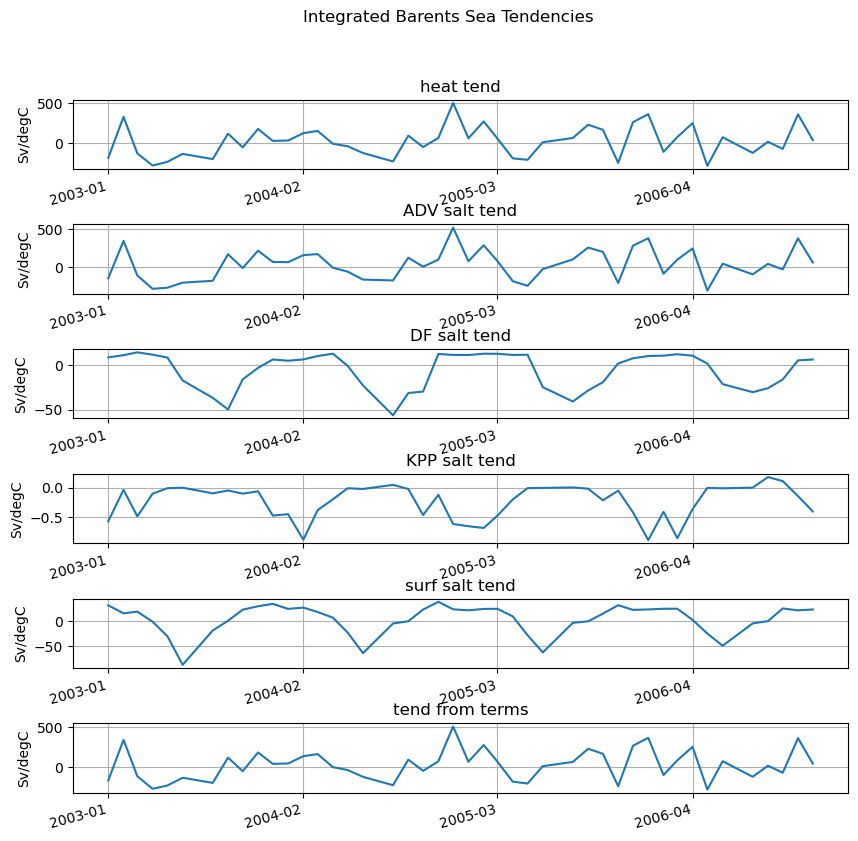

In [47]:
# now we can look at the time series of the salt terms

# now we can look at a time series of each of the J terms for salt at this given cell in a given year

fig = plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.8)  # bigger hspace -- more vertical space

plt.suptitle(("Integrated Barents Sea Tendencies"))

ax = plt.subplot(611)
ax.plot(dates,abcde_values[:,-1])
# coefficients = np.polyfit(np.arange(len(dates)), abcde_values[:,-1], 1)
# trendline = np.polyval(coefficients, np.arange(len(dates)))
# ax.plot(dates, trendline, label="Trendline", color='red', linestyle='--')
ax.set_title("heat tend")
ax.grid()
ax.set_ylabel("Sv/degC")
num_ticks = len(dates)
tick_indices = np.arange(0, num_ticks, 12)  # Indices of every 12th tick
ax.set_xticks(dates[tick_indices])  # Set the positions of the ticks
ax.set_xticklabels(dates[tick_indices].astype(str), rotation=15, ha='right')  # Set the labels and format


ax = plt.subplot(612)
ax.plot(dates,abcde_values[:,0])
ax.set_title("ADV salt tend")
ax.grid()
ax.set_ylabel("Sv/degC")
ax.set_xticks(dates[tick_indices])  # Set the positions of the ticks
ax.set_xticklabels(dates[tick_indices].astype(str), rotation=15, ha='right')  # Set the labels and format

ax = plt.subplot(613)
ax.plot(dates,abcde_values[:,1])
ax.set_title("DF salt tend")
ax.grid()
ax.set_ylabel("Sv/degC")
ax.set_xticks(dates[tick_indices])  # Set the positions of the ticks
ax.set_xticklabels(dates[tick_indices].astype(str), rotation=15, ha='right')  # Set the labels and format

ax = plt.subplot(614)
ax.plot(dates,abcde_values[:,2])
ax.set_title("KPP salt tend")
ax.grid()
ax.set_ylabel("Sv/degC")
ax.set_xticks(dates[tick_indices])  # Set the positions of the ticks
ax.set_xticklabels(dates[tick_indices].astype(str), rotation=15, ha='right')  # Set the labels and format

ax = plt.subplot(615)
ax.plot(dates,abcde_values[:,3])
ax.set_title("surf salt tend")
ax.grid()
ax.set_ylabel("Sv/degC")
ax.set_xticks(dates[tick_indices])  # Set the positions of the ticks
ax.set_xticklabels(dates[tick_indices].astype(str), rotation=15, ha='right')  # Set the labels and format

ax = plt.subplot(616)
ax.plot(dates,abc_minus_d_values)
ax.set_title("tend from terms")
ax.grid()
ax.set_ylabel("Sv/degC")
ax.set_xticks(dates[tick_indices])  # Set the positions of the ticks
ax.set_xticklabels(dates[tick_indices].astype(str), rotation=15, ha='right')  # Set the labels and format

plt.savefig(path + "BarentsSea_saltJterms_ts.png",dpi=300)

In [48]:
dates

array(['2003-01', '2003-02', '2003-03', '2003-04', '2003-05', '2003-06',
       '2003-08', '2003-09', '2003-10', '2003-11', '2003-12', '2004-01',
       '2004-02', '2004-03', '2004-04', '2004-05', '2004-06', '2004-08',
       '2004-09', '2004-10', '2004-11', '2004-12', '2005-01', '2005-02',
       '2005-03', '2005-04', '2005-05', '2005-06', '2005-08', '2005-09',
       '2005-10', '2005-11', '2005-12', '2006-01', '2006-02', '2006-03',
       '2006-04', '2006-05', '2006-06', '2006-08', '2006-09', '2006-10',
       '2006-11', '2006-12'], dtype='datetime64[M]')